# CS 6220 - Data Mining Techniques

## <div style="text-align: center"> Medical Cost Prediction </div>


<div style="text-align: right"> <b> A Project by Team Sage </div>
<div style="text-align: right"> <b> <i>Madhura Prashant Vaidya, Rajkumar Baskar, Shreeyash Amit Yende </div>


The main objective of this project is to predict the premium for an individual based on readily available information that could be utilized to find a pattern from the previous years’ data. Here, we use the Kaggle dataset for insurance forecast, consisting of about 1338 records, each with seven features.

link to dataset: https://www.kaggle.com/datasets/mirichoi0218/insurance

In [1]:
## pip commands that might come handy for missing packages

## pip install seaborn
## pip install matplotlib

In [2]:
# import required modules

import requests
from io import StringIO
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns 


import warnings
warnings.filterwarnings('ignore')

# display the dataframe as an HTML object
def disp_df(df):
    display(HTML(df.to_html(index=False)))

In [3]:
# download and read all zipped input data (downloaded from kaggle and uploaded to personl google drive location)

download_url = "https://drive.google.com/uc?id=1Q88ui4Qa8yrM-EoEdACCBtF0Tq3y1mVo&export=download"
inp_data = pd.read_csv(StringIO(''.join([line for line in requests.get(download_url).content.decode('ISO-8859-1') ])))

# display the first few records to get an insight on the structure of the data
disp_df(inp_data.head())

# display all the feature names
print("Features: ", inp_data.columns.to_list())

age,sex,bmi,children,smoker,region,charges
19,female,27.900,0,yes,southwest,16884.92400
18,male,33.770,1,no,southeast,1725.55230
28,male,33.000,3,no,southeast,4449.46200
33,male,22.705,0,no,northwest,21984.47061
32,male,28.880,0,no,northwest,3866.85520


Features:  ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


The seven features include – age, sex, BMI (body mass index), children count, smoking status, region, and premium/charges. The goal would be to accurately predict the charges for unseen data based on the given information.

In [4]:
# display the size / shape of the dataset
print("Dataset shape: ", inp_data.shape, "\n\n")

# display the data types and other information related to the dataset and its features
inp_data.info()

Dataset shape:  (1338, 7) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### 1. Data Cleaning

In [5]:
# check data for missing values
print(inp_data.isna().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


There seems to be no missing values. Now we check for duplicates and remove them.

In [6]:
# check for duplicates and display it
disp_df(inp_data[inp_data.duplicated()])

# remove the duplicate entries
inp_data.drop_duplicates(inplace=True)

age,sex,bmi,children,smoker,region,charges
19,male,30.59,0,no,northwest,1639.5631


### 2. Data Visualization and Statistics

Split columns into numeric and non-numeric / categorical features.

In [7]:
num_cols = inp_data.select_dtypes(include='number')
cat_cols = inp_data.select_dtypes(exclude='number')

Acquiring the statistics / range for the numerical features..

In [8]:
inp_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


.. and the unique values of non-numeric features.

In [9]:
for col in cat_cols:
    print(f"Feature: {col.ljust(10)}  -  Unique Values: {inp_data[col].unique()}")

Feature: sex         -  Unique Values: ['female' 'male']
Feature: smoker      -  Unique Values: ['yes' 'no']
Feature: region      -  Unique Values: ['southwest' 'southeast' 'northwest' 'northeast']


Plotting the distribution of data across all features..

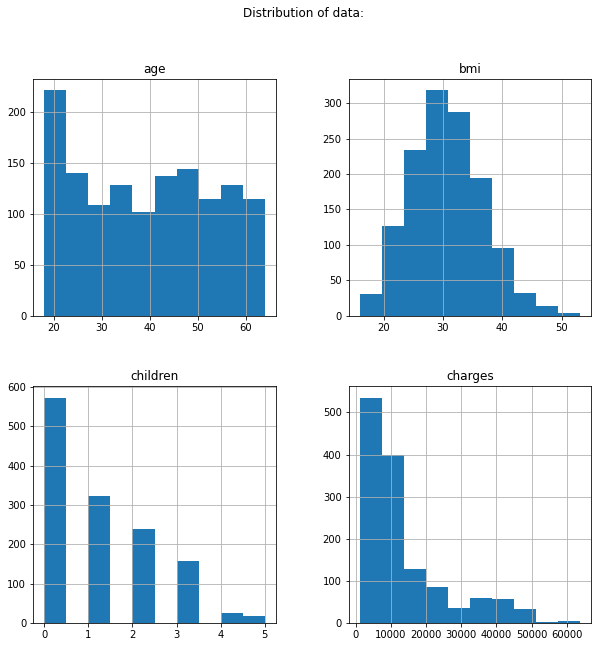

In [10]:
# plot the distribution of numeric features

inp_data.hist(figsize=(10, 10))
plt.suptitle("Distribution of data:");

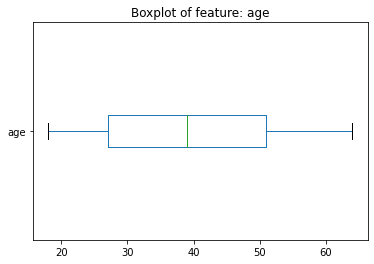

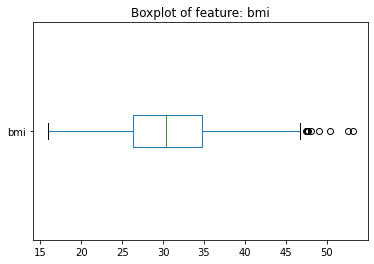

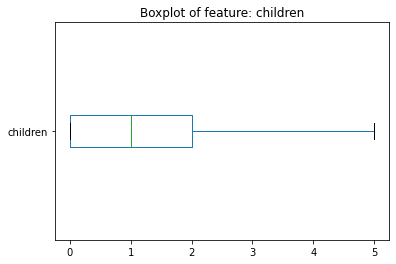

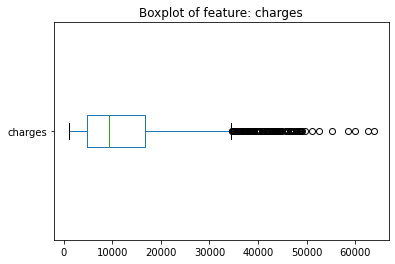

In [11]:
# plot the range of numeric features to understand the trend and outliers

for col in num_cols:
    inp_data.boxplot(column=col, grid=False, vert=False);
    plt.title(f"Boxplot of feature: {col}")
    plt.show()

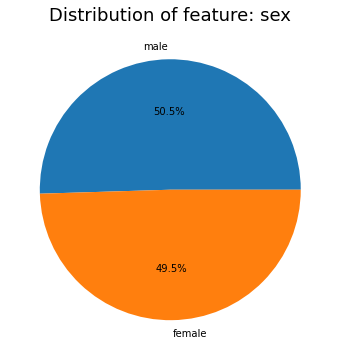

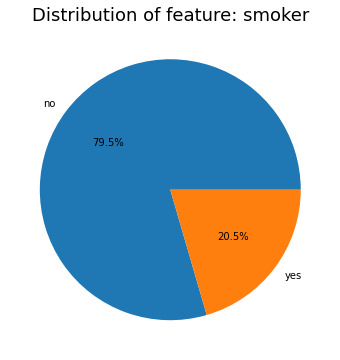

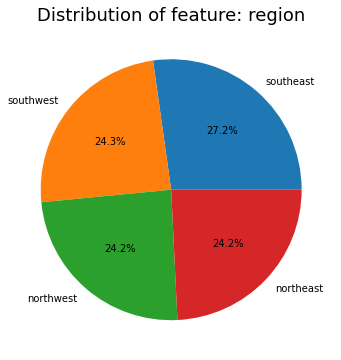

In [12]:
# plot the distribution of categorical features


for col in cat_cols:
    inp_data[col].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6, 6), legend=False);
    plt.title(f"Distribution of feature: {col}", fontdict={'fontsize':18})
    plt.ylabel('')
    plt.show()

Plotting the correlation among features..

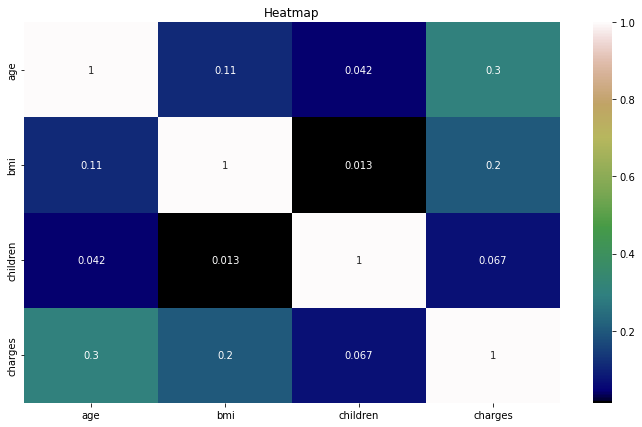

In [13]:
plt.figure(figsize=(12,7))
sns.heatmap(inp_data.corr(),annot=True,cmap='gist_earth')
plt.title("Heatmap")
plt.show()

and plotting all features against charges, distinguishing data points by age range..

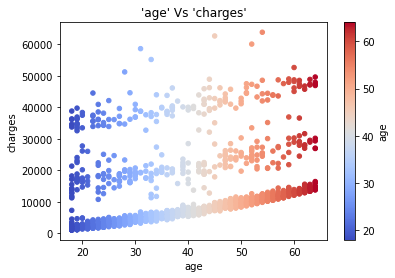

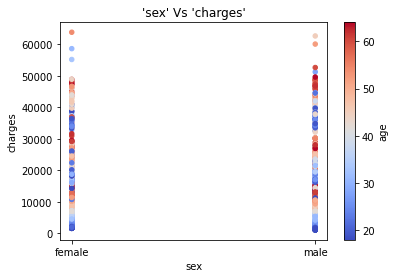

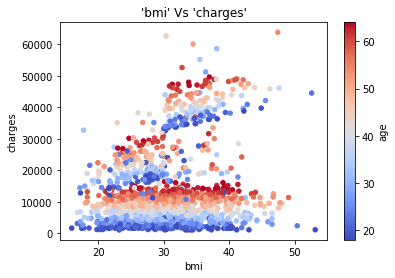

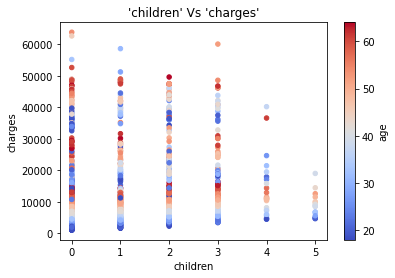

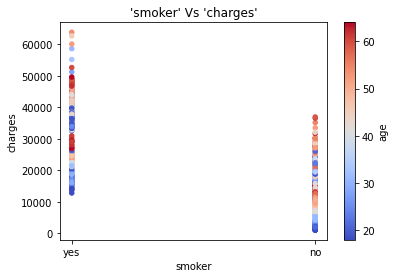

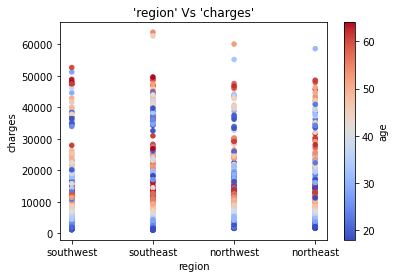

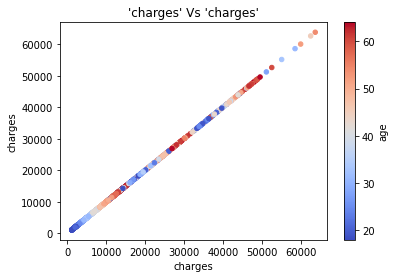

In [14]:
for col in inp_data.columns:
    inp_data.plot.scatter(x=col, y='charges', c='age', colormap='coolwarm', sharex=False);
    plt.title(f"'{col}' Vs 'charges'")
    plt.show()

### 3. Observations and Deductions

From the heatmap of correlation matrix, we can observe that there is almost no significant correlation between any two features at all, since everything is below 0.3 .

It can be noted from the above that the 'bmi' feature has an intriguing pattern which will be discussed in detail below.

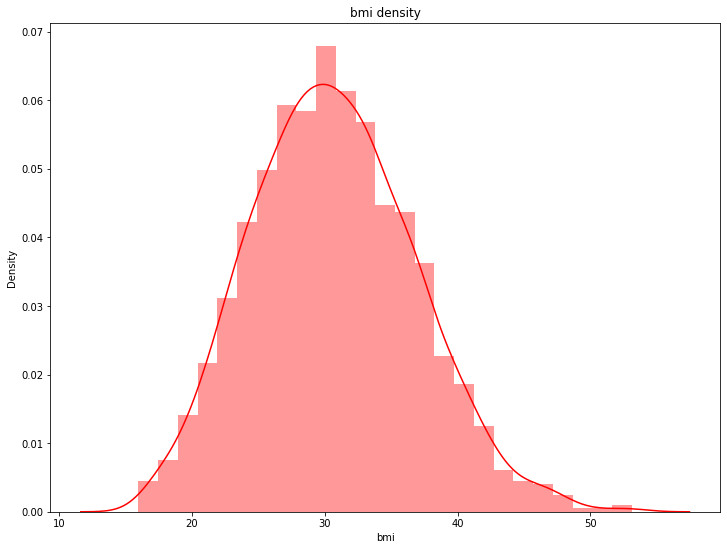

In [15]:
# BMI density plot

plt.figure(figsize=(12,9))
sns.distplot(inp_data.bmi,color='red')
plt.title('bmi density')
plt.show()

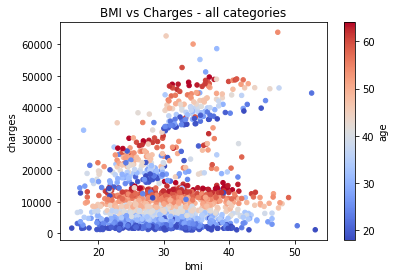

In [16]:
#BMI Scatter plot

inp_data.plot.scatter(x='bmi', y='charges', c='age', colormap='coolwarm', sharex=False);
plt.title("BMI vs Charges - all categories")
plt.show()

There are three different clusters for range of age groups above. This can be further broken down to distinguish them clearly as follows.

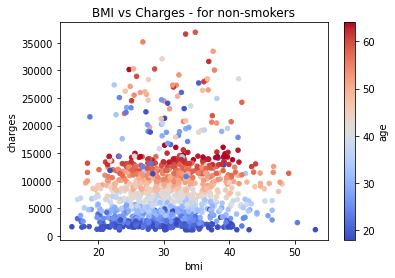

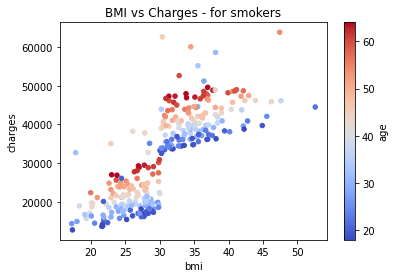

In [17]:
# non-smoker BMI scatter plot

inp_data[inp_data.smoker=='no'].plot.scatter(x='bmi', y='charges', c='age', colormap='coolwarm', sharex=False);
plt.title("BMI vs Charges - for non-smokers")
plt.show()

# smoker BMI scatter plot

inp_data[inp_data.smoker=='yes'].plot.scatter(x='bmi', y='charges', c='age', colormap='coolwarm', sharex=False);
plt.title("BMI vs Charges - for smokers")
plt.show()

The non-smoker pattern is easily understandable where the charges increase over age irrespective of their bmi. However, for smokers, the charges are very high if the bmi crossed 30. It is almost a shift of charges upwards considerably irrespective of age. This means that a smoking individual with bmi>30 pays up an extra premium because of their unhealthy lifestyle which makes them susceptible to utilization of healthcare more often. 

Another thing to be noted, which is obvious, is that the smokers are charged a higher premium than non-smokers. This can be seen from the unfiltered graph above showing three clusters where non-smokers are placed as the bottom cluster, smoking individuals with bmi<30 placed in the mid-left and the smoking individuals with bmi>30 at the top-right. 

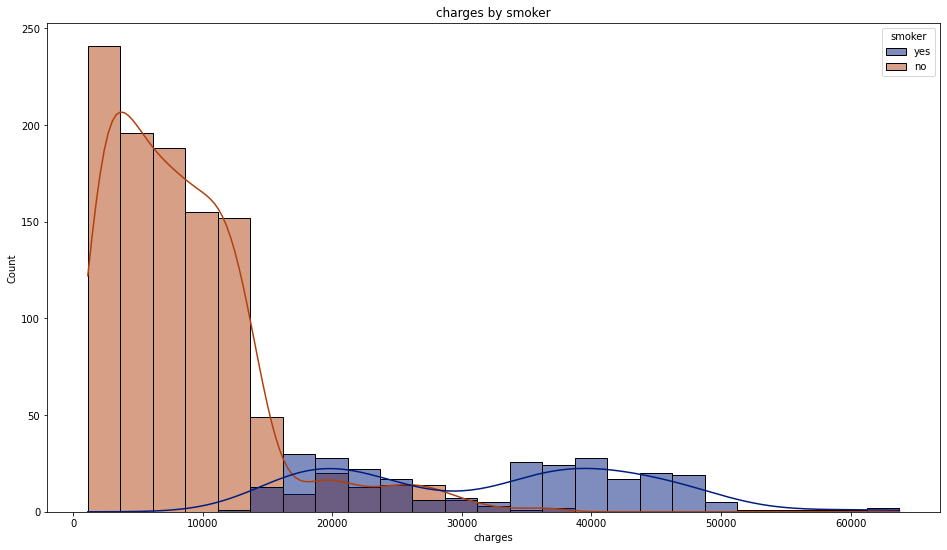

In [18]:
# smoker counts against charges

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.set_palette('dark')
sns.histplot(data = inp_data, x='charges', ax=ax1, bins=25, hue='smoker', kde=True)
plt.title('charges by smoker')
plt.show()

As seen above, smoking status holds a considerable hold on charges, with difference in bmi. However, genders do not play much of a difference. The gender density plot against bmi below can back up the statement.

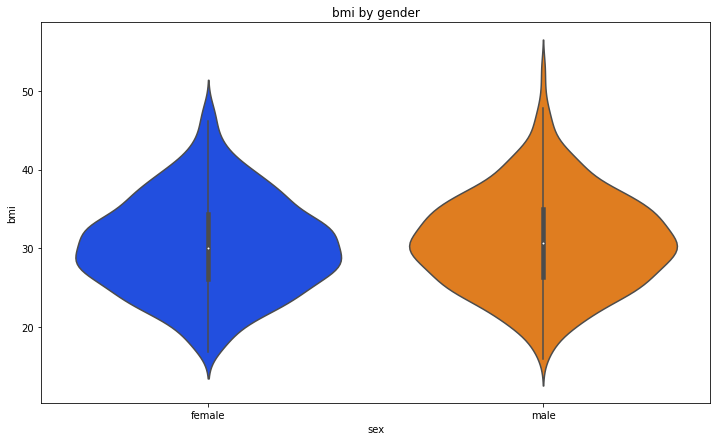

In [19]:
plt.figure(figsize=(12,7))
sns.set_palette('bright')
sns.violinplot(x=inp_data.sex,y=inp_data.bmi)
plt.title('bmi by gender')
plt.show()

Although all the categorical features are almost evenly spread, except the smokers vs non-smokers, this can be further broken down gender-wise for better observation.

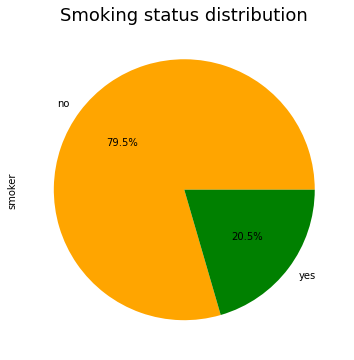

In [20]:
# smoker vs non-smoker ratio

inp_data['smoker'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6, 6), legend=False, colors=['orange', 'green']);
plt.title(f"Smoking status distribution", fontdict={'fontsize':18})
plt.show()

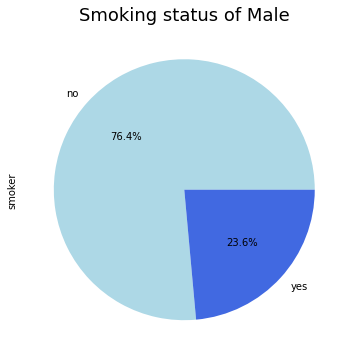

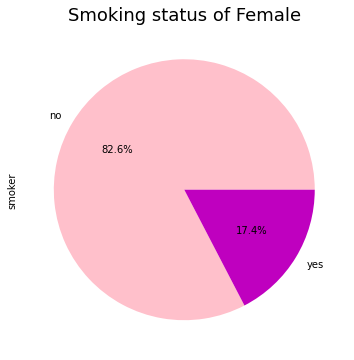

In [21]:
# male smoker ratio

inp_data[inp_data.sex=='male']['smoker'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6, 6), legend=False, colors=['lightblue', 'royalblue']);
plt.title(f"Smoking status of Male", fontdict={'fontsize':18})
plt.show()

# female smoker ratio

inp_data[inp_data.sex=='female']['smoker'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6, 6), legend=False, colors=['pink', 'm']);
plt.title(f"Smoking status of Female", fontdict={'fontsize':18})
plt.show()

Thus shoiws that the percentage of female smokers, as compared to male smokers, are almost similar, even if less by a few percentage, indicating that the dataset is as good as an even-spread, irrespective of gender.

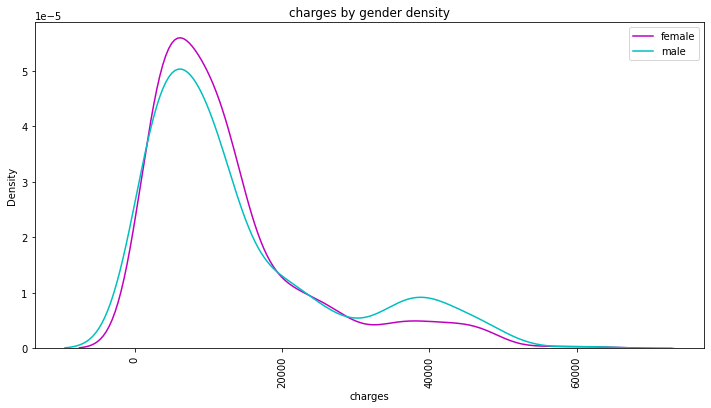

In [22]:
plt.figure(figsize=(12,6))
sns.kdeplot(inp_data[inp_data.sex=='female']['charges'], color='m', label='female')
sns.kdeplot(inp_data[inp_data.sex=='male']['charges'], color='c', label='male')
plt.title('charges by gender density')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

and the charges drawn up against gender density also reveals the same, that the dataset is more or less evenly spread.

Another peculiar observation from the boxplots is the outliers for premium/charges. 

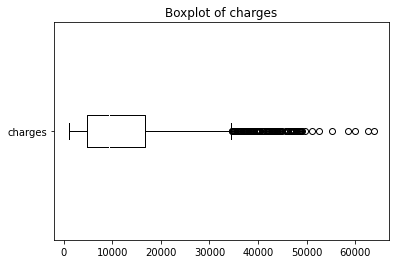

In [23]:
inp_data.boxplot(column='charges', grid=False, vert=False);
plt.title(f"Boxplot of charges")
plt.show()

Since 80% of the data consists of non-smokers, one could assume the initial box defining charges describes them, while the rest 20% being considered outliers and populated densely around the 35k to 50k mark. On dividing based on smoking status, we can observe as follows.

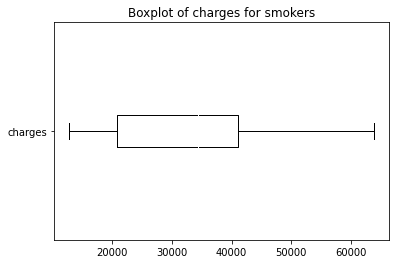

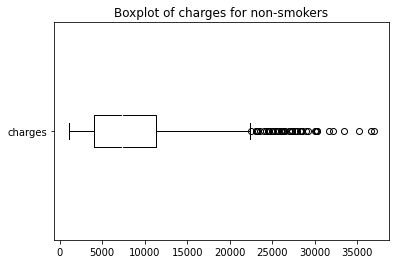

In [24]:
inp_data[inp_data.smoker=='yes'].boxplot(column='charges', grid=False, vert=False);
plt.title(f"Boxplot of charges for smokers")
plt.show()

inp_data[inp_data.smoker=='no'].boxplot(column='charges', grid=False, vert=False);
plt.title(f"Boxplot of charges for non-smokers")
plt.show()

The outliers, if not dense, are still widely present for charges of non-smokers. This could only mean there is some other controlling factor for such outliers. 

While there are other observations from distribution data that could be explored in detail, they are almost evenly or uniformly spread and not of much importance to go in detail. So, we move onto the model exploration now that the data is set and analyzed.

### 4. Data Pre-processing

First, we change all the non-numeric features into numeric values by assigning some unique integer value for every category in them.

In [25]:
# convert categorical features to numeric values

inp_data.region=inp_data.region.map({'southwest':0,'southeast':1,'northwest':2,'northeast':3})
inp_data.smoker=inp_data.smoker.map(lambda row: 1 if row=='yes' else 0)
inp_data.sex=inp_data.sex.map(lambda row: 1 if row=='male' else 0)
disp_df(inp_data.head())

age,sex,bmi,children,smoker,region,charges
19,0,27.900,0,1,0,16884.92400
18,1,33.770,1,0,1,1725.55230
28,1,33.000,3,0,1,4449.46200
33,1,22.705,0,0,2,21984.47061
32,1,28.880,0,0,2,3866.85520


Now we split the data into training and test set, with charges as the destination value for prediction (i.e. y) and all other features to be input (i.e. X). 

Training set - 75% of input data  
Testing set  - 25% of input data

In [26]:
# split dataset to train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(inp_data.loc[:, inp_data.columns != 'charges'], 
                                                    inp_data.loc[:, inp_data.columns == 'charges'], 
                                                    test_size=0.25, random_state=42)

In [27]:
# Print all dataset shapes

print("Train input shape  :", X_train.shape)
print("Train output shape :", y_train.shape)
print("Test input shape   :", X_test.shape)
print("Test output shape  :", y_test.shape)

Train input shape  : (1002, 6)
Train output shape : (1002, 1)
Test input shape   : (335, 6)
Test output shape  : (335, 1)


Now, we scale the input features using a min-max scaler.

In [28]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
X_train_scaled = minmax.fit_transform(X_train)
X_test_scaled = minmax.transform(X_test)

### 5. Modeling

Since the dataset involves a prediction task, we will explore the basic regression models such as linear and Bayesian regressors as they both use linear relationships, and then move to few other various regressors available to compare performances.

In [29]:
## import the model library

from sklearn.linear_model import LinearRegression, BayesianRidge   

## import and create the model object
model_BR = BayesianRidge()
model_LR = LinearRegression() 

## fitting the training data
model_BR = model_BR.fit(X_train_scaled,y_train)
model_LR = model_LR.fit(X_train_scaled,y_train) 


Now that the models are trainied, we report all the statistics involved for both of them to analyze their performance.

In [30]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math

models = {
    'Bayesian Regressor': model_BR,
    'Linear Regression': model_LR
}

# report metrics for both models
for model_name, model in models.items():
    print(model_name)
    print()
    
    # get predictions on both train and test data
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # get prediction scores (R2 metrics)
    train_score = r2_score(y_train,y_train_pred)
    test_score = r2_score(y_test,y_test_pred)
    print('Training score :', train_score)
    print('Testing score :', test_score)
    print()
    
    # calculate and report adjusted R2 score
    train_adjusted_r2_score = 1 - ( (1 - train_score) * (X_train_scaled.shape[0] - 1) / 
                                   (X_train_scaled.shape[0] - X_train_scaled.shape[1] - 1) )
    test_adjusted_r2_score = 1 - ( (1 - test_score) * (X_test_scaled.shape[0] - 1) / 
                                  (X_test_scaled.shape[0] - X_test_scaled.shape[1] - 1) )
    
    print('Adjusted R2 Score - Training Data:', train_adjusted_r2_score)
    print('Adjusted R2 Score - Test Data:', test_adjusted_r2_score)
    print()
    
    # get Mean Squared Error (MSE), Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
    print('Training data')
    print('MSE:',mean_squared_error(y_train,y_train_pred))
    print('MAE:',mean_absolute_error(y_train,y_train_pred))
    print('RMSE:',math.sqrt(mean_squared_error(y_train,y_train_pred)))
    print()
    print('Testing data')
    print('MSE:',mean_squared_error(y_test,y_test_pred))
    print('MAE:',mean_absolute_error(y_test,y_test_pred))
    print('RMSE:',math.sqrt(mean_squared_error(y_test,y_test_pred)))
    print()
    print()

Bayesian Regressor

Training score : 0.7294309024962361
Testing score : 0.7958355932839731

Adjusted R2 Score - Training Data: 0.7277993300489772
Adjusted R2 Score - Test Data: 0.7921008785269726

Training data
MSE: 37225970.88231629
MAE: 4208.366784902875
RMSE: 6101.308948276287

Testing data
MSE: 35302029.73843685
MAE: 4063.000193051111
RMSE: 5941.551122260655


Linear Regression

Training score : 0.7294365233101179
Testing score : 0.7962578620326625

Adjusted R2 Score - Training Data: 0.7278049847572141
Adjusted R2 Score - Test Data: 0.7925308717039916

Training data
MSE: 37225197.548421815
MAE: 4210.575616626599
RMSE: 6101.245573522001

Testing data
MSE: 35229015.3273374
MAE: 4063.0773793105764
RMSE: 5935.403552188966




From the statistics, it can be observed that, both of them behave almost similarly, since they both are linear models after all. The below density plot of charge predictions against test data would give a better insight.

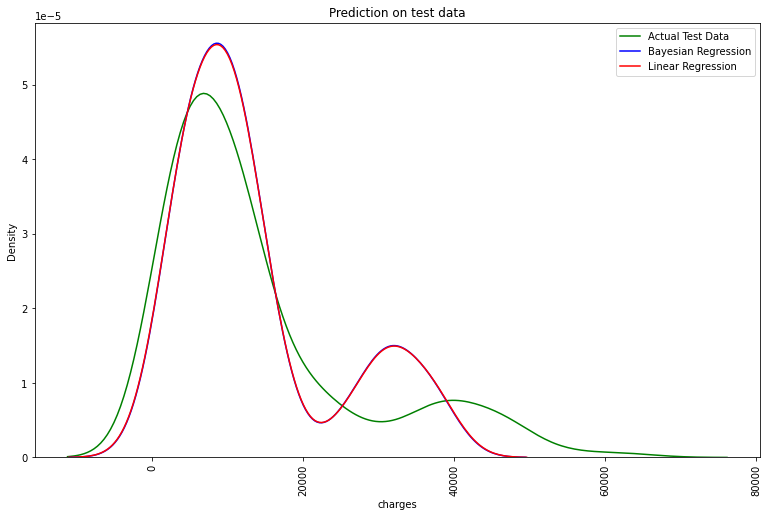

In [31]:
plt.figure(figsize=(13,8))
sns.distplot(y_test.charges, color='green', label='Actual Test Data', hist=None)
sns.distplot(model_BR.predict(X_test_scaled), color='blue', label='Bayesian Regression', kde=True, hist=None)
sns.distplot(model_LR.predict(X_test_scaled), color='red', label='Linear Regression', kde=True, hist=None)
plt.title('Prediction on test data')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

As it can be seen above, both the models are almost overlapping with each other. Although the prediction curves are somewhat overlapping with the actual data, they are a bit squeezed on the X-axis, which is the reason for an accuracy of less than 80%.

**For the comparison part we will compare 7 other algorithms for Regression against the Linear Regression model:**

1: Linear Regression

2: Ridge

3: Lasso

4: SVR

5: DecisionTreeRegressor

6: RandomForestRegressor

7: ExtraTreesRegressor

8: GradientBoostingRegressor

Here, we will list all available parameters for each model and choose the best out of them using Grid Search for model selection.

In [32]:
# import all the required comparison models

from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

In [33]:
# define a k-fold object to shuffle between parameters for a given model and choose the best out of it.
# Here, no of splits is taken as 3, with a fixed random state and shuffle enabled.

from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)


# Define all regressors and append them in a common list

regressors = []
regressors.append(LinearRegression())
regressors.append(Ridge())
regressors.append(Lasso())
regressors.append(SVR())
regressors.append(DecisionTreeRegressor())
regressors.append(RandomForestRegressor())
regressors.append(ExtraTreesRegressor())
regressors.append(GradientBoostingRegressor())

# copy the models for to perform actual testing after choosing best parameters
import copy

regression_models = copy.deepcopy(regressors)

# Add corresponding names to another list
regressor_names = [
    'Linear Regression',
    'Ridge Regression',
    'Lasso Regression',
    'SVR',
    'Decision Tree Regressor',
    'Random Forest Regressor',
    'Extra Trees Regressor',
    'Gradient Boosting Regressor'
]

In [34]:
# import and use Grid Search for choosing best model out of given parameters

from sklearn.model_selection import GridSearchCV



# define parameters for each model to use in GridSearchCV

param_grid_LR = {'fit_intercept':[True,False],
                'normalize':[True,False],
                 'copy_X':[True,False]}

param_grid_Ridge = {'alpha': [1,0.1,0.01,0.001,0.0001],
                    "fit_intercept": [True, False],
                    "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

param_grid_Lasso = {'alpha': [1,0.1,0.01,0.001,0.0001],
                    "fit_intercept": [True, False]}

param_grid_SVR = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                   'C' : np.logspace(-3,3,7),
                   'gamma' : ['auto','scale']}

param_grid_DT = {"splitter":["best","random"],
                 "max_depth" : [1,3,5,9,12],
                 "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
                 "min_weight_fraction_leaf":[0.1,0.3,0.5,0.7,0.9],
                 "max_features":["auto","log2","sqrt",None],
                 "max_leaf_nodes":[None,10,20,30,50,80]}

param_grid_RF = {'n_estimators': [100,200,300],
                 'max_features': ['auto', 'sqrt', 'log2'],
                 'max_depth' : np.arange(3,15)}

param_grid_ET = {'n_estimators': [100,200,300],
                 'max_features': ['auto', 'sqrt', 'log2'],
                 'max_depth' : np.arange(3,15)}

param_grid_GB = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample' : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,200,300],
                  'max_depth' : np.arange(5,15)}


# Create a list and append all parameters corresponding to previously created lists
grid_params = []
grid_params.append(param_grid_LR)
grid_params.append(param_grid_Ridge)
grid_params.append(param_grid_Lasso)
grid_params.append(param_grid_SVR)
grid_params.append(param_grid_DT)
grid_params.append(param_grid_RF)
grid_params.append(param_grid_ET)
grid_params.append(param_grid_GB)

Before moving to the model training, we report the best parameters chosen for each model by GridSearchCV.

In [35]:
# perform grid search and report best parameters

best_parameters = []

for model_name, model, params in zip(regressor_names, regressors, grid_params):
    grid = GridSearchCV(model, params, cv=kf, n_jobs=-1 )
    grid = grid.fit(X_train_scaled,y_train)
    best_parameters.append(grid.best_params_)
    print(f'Best parameters for {model_name}: ', grid.best_params_)
    print()

Best parameters for Linear Regression:  {'copy_X': True, 'fit_intercept': True, 'normalize': True}

Best parameters for Ridge Regression:  {'alpha': 0.001, 'fit_intercept': True, 'solver': 'sag'}

Best parameters for Lasso Regression:  {'alpha': 1, 'fit_intercept': True}

Best parameters for SVR:  {'C': 1000.0, 'gamma': 'scale', 'kernel': 'poly'}

Best parameters for Decision Tree Regressor:  {'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}

Best parameters for Random Forest Regressor:  {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}

Best parameters for Extra Trees Regressor:  {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 300}

Best parameters for Gradient Boosting Regressor:  {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}



Now we use the best parameters on the available training and test set to compare model performances at their best.

In [36]:
model_scores = {}
model_predictions = {}

for model_name, model, params in zip(regressor_names, regression_models, best_parameters):
    model.set_params(**params)
    model = model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    model_predictions[model_name] = y_pred
    model_score = r2_score(y_test, y_pred)
    model_scores[model_name] = model_score

The accuracy of each model is listed in decreasing order below:

In [37]:
final_result = pd.DataFrame(pd.Series(model_scores),columns=['Accuracy']).sort_values(by = 'Accuracy', ascending=False)
final_result

,Accuracy
Random Forest Regressor,0.885752
Extra Trees Regressor,0.884520
Gradient Boosting Regressor,0.880323
Decision Tree Regressor,0.864458
SVR,0.862101
Linear Regression,0.796258
Ridge Regression,0.796233
Lasso Regression,0.796148


It is clear that the basic regressors - linear, lasso and ridge, have an accuracy of only 79%, while the complicated regressors like random forest, extra trees and gradient boosting regressors have a much higher accuracy of about 88%. Decision Trees and SVRs lie in the middle with about 86% accuracy. 

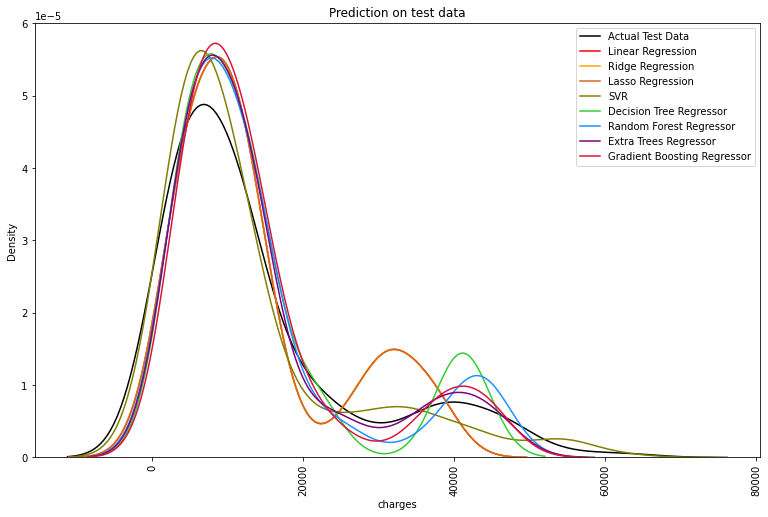

In [38]:
plt.figure(figsize=(13,8))
plt_colors = ['red', 'orange', 'chocolate', 'olive', 'limegreen', 'dodgerblue', 'purple', 'crimson']
sns.distplot(y_test.charges, color='black', label='Actual Test Data', hist=None)
i = 0
for model_name, y_pred in model_predictions.items():
    sns.distplot(y_pred, color=plt_colors[i], label=model_name, kde=True, hist=None)
    i += 1
plt.title('Prediction on test data')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

The density plot above shows how close the regressors fare against the actual test data. It is very evident that linear regressor has the worst performance among other regressors just by looking at the density plot.   
Note: This is only a density plot and not the actual predicted data. Hence, this is not a metric that is ideal for comparison of performances. It is just to visualize the distribution of the predicted charges for each of the regressors. 